In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import metrics, feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import torch

## for bert language model
import transformers
from transformers import AutoTokenizer, AutoModel

In [2]:
''' The following shows the result of training various non-neural network models on an augmented version of the 
Kannada set so that the negative label equals the positive label. models are trained on an bert vectorizer'''

' The following shows the result of training various non-neural network models on an augmented version of the \nKannada set so that the negative label equals the positive label. models are trained on an bert vectorizer'

In [3]:
# import data
kan_train = pd.read_table("../../datasets/task_a/kan_train_negative_augmented.tsv")
kan_dev = pd.read_table("../../datasets/task_a/kan_sentiment_dev.tsv")

In [4]:
kan_train = kan_train.rename(columns={'category': 'y'})
kan_dev = kan_dev.rename(columns={'category': 'y'})

In [5]:
kan_dev

,text,y
0,Binduge saryagi ugithidira good go ahead we a...,Mixed feelings
1,yen song guru ...super,Positive
2,my fevorat story,not-Kannada
3,Super ತೋಗರಿ ತೀಪ್ಪ,Positive
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...,Positive
...,...,...
686,@Nandi Parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative
687,Hugi guru badethawke,Negative
688,Trending no.1 wow,Positive
689,@Troll Stupid Fans naanu adikke kano helthirod...,Positive


In [6]:
kan_train

,text,y
0,ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...,Negative
1,ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...,Positive
2,Super sar song,not-Kannada
3,Tiktokers present situation... nನೋಡುವವರು ಯಾರು ...,Negative
4,Super ಸಾಂಗ್ ವೆರಿ ನೈಸ್....,Positive
...,...,...
7842,ಇಡೈಲಾ ಕೆಜಿಎಫ್ ಬಿಜಿಎಂ ಕೆಡತು ಎನಕು ಮಧುಮಥಾನ 🤔🤔🤔🤔🤯,Negative
7843,ಜಯಲಲಿತಾ ಮೇಡಂ ಅವರಿಗೆ ಅಮೋಘ ನಿಗ್ರಹ...,Negative
7844,ದಯವಿಟ್ಟು ಎಲ್ಲದರ ಚಿತ್ರ ತೆಗೆಯಿರಿ ಸರ್.,Negative
7845,ಭಾರತದ ಅತಿ ದೊಡ್ಡ ಹೆದ್ದಾರಿ! ಭಾರತದ ದೊಡ್ಡ ತಾರೆಗಳು!...,Negative


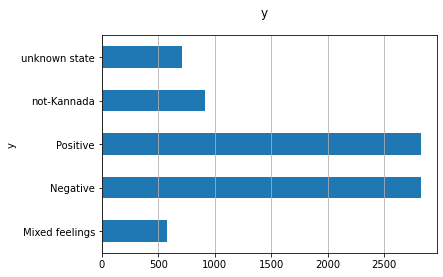

In [7]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
kan_train.groupby("y").count().plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [8]:
# Now we can define our training data and our dev data as well as targets
train = kan_train
test = kan_dev

y_train = kan_train['y'].values
y_test = kan_dev['y'].values


In [9]:
# for ensemble: 
results = pd.DataFrame(kan_dev['y'])

# Gettint text embeddings from the bert model

In [10]:
# I'll be using the embeddings from the multilinngual bert model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = AutoModel.from_pretrained('bert-base-multilingual-uncased').to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# We will start by gathering the embeddings for the validation set
cls_val_list = []
batch_size = 1000

for batch_number, batch_test in test.groupby(np.arange(len(test)) // batch_size):
    # tokanizing the text
    tokenized_val = tokenizer(batch_test["text"].values.tolist() , padding = 'max_length', truncation = True,  return_tensors="pt", max_length=256)

    # move on device (GPU)
    tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}

    # get the cls hidden state
    with torch.no_grad():
        hidden_val = model(**tokenized_val)
            
    #get only the [CLS] hidden states
    cls_val = hidden_val.last_hidden_state[:,0,:]
    cls_val = cls_val.to("cpu")
    cls_val_list.append(cls_val)
    del cls_val
    del hidden_val
    del tokenized_val
    
    torch.cuda.empty_cache()

cls_val_list_final = []
for i in range(len(cls_val_list)):
    for j in range(len(cls_val_list[i])):
        cls_val_list_final.append(cls_val_list[i][j])

/home/ubuntu/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [12]:
# Get embeddigns for the trainins set
cls_train_list = []
batch_size = 1000

for batch_number, batch_train in train.groupby(np.arange(len(train)) // batch_size):
    # tokanizing the text
    tokenized_train = tokenizer(batch_train["text"].values.tolist() , padding = 'max_length', truncation = True,  return_tensors="pt", max_length=256)

    # move on device (GPU)
    tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}

    # get the cls hidden state
    with torch.no_grad():
        hidden_train = model(**tokenized_train)
            
    #get only the [CLS] hidden states
    cls_train = hidden_train.last_hidden_state[:,0,:]
    cls_train = cls_train.to("cpu")
    cls_train_list.append(cls_train)
    del cls_train
    del hidden_train
    del tokenized_train
    
    torch.cuda.empty_cache()

cls_train_list_final = []
for i in range(len(cls_train_list)):
    for j in range(len(cls_train_list[i])):
        cls_train_list_final.append(cls_train_list[i][j])

/home/ubuntu/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [13]:
len(cls_val_list_final)

691

In [14]:
len(cls_train_list_final)

7847

In [15]:
X_train = torch.stack(cls_train_list_final)
X_train = pd.DataFrame(X_train)
X_test = torch.stack(cls_val_list_final)
X_test = pd.DataFrame(X_test)

y_train = kan_train['y'].values
y_test = kan_dev['y'].values

# Training a cat boost classifier

In [16]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(
    iterations=180, 
    learning_rate=.8, 
    #loss_function='CrossEntropy'
)


In [17]:
## train classifier
cat.fit(X_train, y_train)
predicted = cat.predict(X_test)
results['cat_boost_neg_bert'] = predicted
predicted_prob = cat.predict_proba(X_test)

0:	learn: 1.2753231	total: 685ms	remaining: 2m 2s
1:	learn: 1.2109927	total: 1.05s	remaining: 1m 33s
2:	learn: 1.1610282	total: 1.48s	remaining: 1m 27s
3:	learn: 1.1263691	total: 1.86s	remaining: 1m 21s
4:	learn: 1.0987560	total: 2.24s	remaining: 1m 18s
5:	learn: 1.0717563	total: 2.62s	remaining: 1m 15s
6:	learn: 1.0517400	total: 3s	remaining: 1m 14s
7:	learn: 1.0314840	total: 3.37s	remaining: 1m 12s
8:	learn: 1.0059292	total: 3.74s	remaining: 1m 11s
9:	learn: 0.9898275	total: 4.11s	remaining: 1m 9s
10:	learn: 0.9706538	total: 4.5s	remaining: 1m 9s
11:	learn: 0.9501629	total: 4.87s	remaining: 1m 8s
12:	learn: 0.9378949	total: 5.23s	remaining: 1m 7s
13:	learn: 0.9246136	total: 5.59s	remaining: 1m 6s
14:	learn: 0.9086223	total: 5.96s	remaining: 1m 5s
15:	learn: 0.8962478	total: 6.31s	remaining: 1m 4s
16:	learn: 0.8798263	total: 6.68s	remaining: 1m 4s
17:	learn: 0.8689316	total: 7.02s	remaining: 1m 3s
18:	learn: 0.8588913	total: 7.36s	remaining: 1m 2s
19:	learn: 0.8420928	total: 7.74s	rem

161:	learn: 0.2208725	total: 57.9s	remaining: 6.43s
162:	learn: 0.2189169	total: 58.2s	remaining: 6.07s
163:	learn: 0.2176590	total: 58.6s	remaining: 5.72s
164:	learn: 0.2160867	total: 59s	remaining: 5.36s
165:	learn: 0.2152406	total: 59.3s	remaining: 5s
166:	learn: 0.2144673	total: 59.6s	remaining: 4.64s
167:	learn: 0.2132880	total: 60s	remaining: 4.29s
168:	learn: 0.2122400	total: 1m	remaining: 3.93s
169:	learn: 0.2098751	total: 1m	remaining: 3.57s
170:	learn: 0.2083538	total: 1m 1s	remaining: 3.21s
171:	learn: 0.2069802	total: 1m 1s	remaining: 2.86s
172:	learn: 0.2059286	total: 1m 1s	remaining: 2.5s
173:	learn: 0.2050833	total: 1m 2s	remaining: 2.14s
174:	learn: 0.2040713	total: 1m 2s	remaining: 1.78s
175:	learn: 0.2032081	total: 1m 2s	remaining: 1.43s
176:	learn: 0.2024290	total: 1m 3s	remaining: 1.07s
177:	learn: 0.2010802	total: 1m 3s	remaining: 713ms
178:	learn: 0.1999236	total: 1m 3s	remaining: 357ms
179:	learn: 0.1992284	total: 1m 4s	remaining: 0us


Accuracy: 0.54
Auc: 0.74
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.23      0.12      0.15        52
      Negative       0.44      0.54      0.49       139
      Positive       0.64      0.66      0.65       321
   not-Kannada       0.61      0.55      0.58       110
 unknown state       0.29      0.26      0.27        69

      accuracy                           0.54       691
     macro avg       0.44      0.43      0.43       691
  weighted avg       0.53      0.54      0.53       691



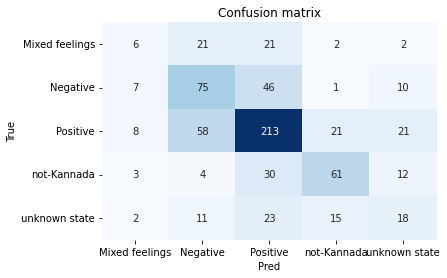

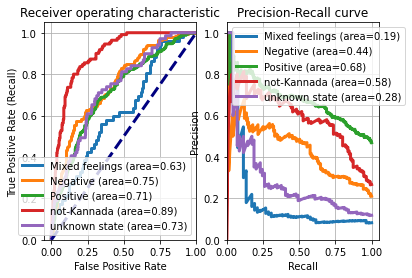

In [18]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Training a Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=150, n_estimators=15, max_features=768)

In [20]:

## train classifier
forest.fit(X_train, y_train)
## test
predicted = forest.predict(X_test)
results['forest_neg_bert'] = predicted
predicted_prob = forest.predict_proba(X_test)

Accuracy: 0.5
Auc: 0.72
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.24      0.10      0.14        52
      Negative       0.38      0.55      0.45       139
      Positive       0.56      0.62      0.59       321
   not-Kannada       0.56      0.46      0.51       110
 unknown state       0.55      0.17      0.26        69

      accuracy                           0.50       691
     macro avg       0.46      0.38      0.39       691
  weighted avg       0.50      0.50      0.48       691



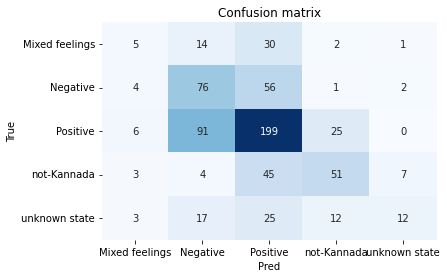

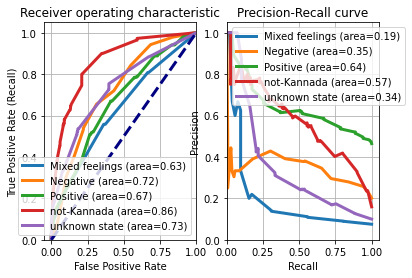

In [21]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# fitting a logistic regression classifier

In [22]:
from sklearn.linear_model import LogisticRegression
log =LogisticRegression(random_state=0, max_iter= 1000)

In [23]:
## pipeline

## train classifier
log.fit(X_train, y_train)
## test
predicted = log.predict(X_test)
results['log_neg_bert'] = predicted
predicted_prob = log.predict_proba(X_test)

/home/ubuntu/pyenv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.58
Auc: 0.81
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.25      0.02      0.04        52
      Negative       0.45      0.59      0.51       139
      Positive       0.64      0.71      0.67       321
   not-Kannada       0.62      0.65      0.63       110
 unknown state       0.54      0.28      0.37        69

      accuracy                           0.58       691
     macro avg       0.50      0.45      0.44       691
  weighted avg       0.56      0.58      0.56       691



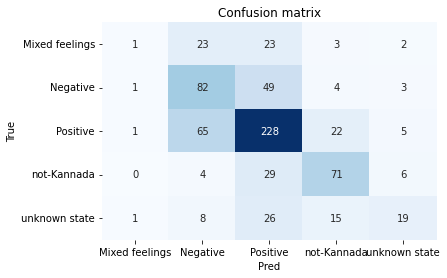

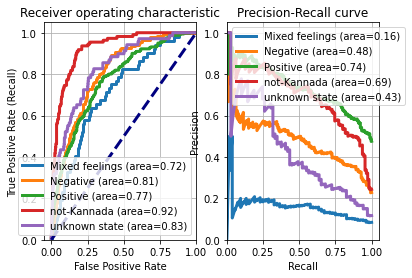

In [24]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# training a k-neighboot classifier

In [25]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=8, weights='distance')

In [26]:

## train classifier
neigh.fit(X_train, y_train)
## test
predicted = neigh.predict(X_test)
results['neigh_neg_bert'] = predicted
predicted_prob = neigh.predict_proba(X_test)

Accuracy: 0.59
Auc: 0.75
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.30      0.12      0.17        52
      Negative       0.48      0.66      0.56       139
      Positive       0.67      0.68      0.68       321
   not-Kannada       0.60      0.63      0.61       110
 unknown state       0.55      0.30      0.39        69

      accuracy                           0.59       691
     macro avg       0.52      0.48      0.48       691
  weighted avg       0.58      0.59      0.58       691



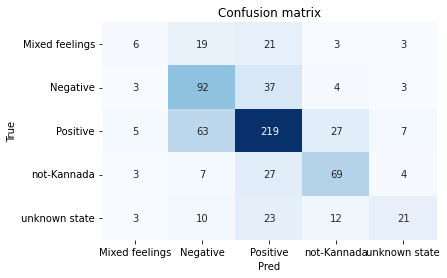

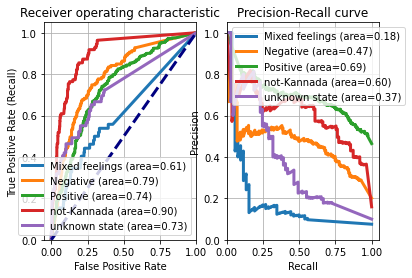

In [27]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Ensemble

In [28]:
results.replace(['Negative', 'Positive','not-Kannada', 'Mixed feelings','unknown state' ], [0,1,2,3,4], inplace=True)
results['neg_majority_label_bert'] = results[results.columns[1:]].mode(axis=1)[0].astype(int)
results.replace([0,1,2,3,4], ['Negative', 'Positive','not-Kannada', 'Mixed feelings','unknown state' ], inplace=True)
results.to_csv('kan_results_neg_bert.tsv', sep="\t", index = False)

                precision    recall  f1-score   support

Mixed feelings       0.60      0.06      0.11        52
      Negative       0.44      0.69      0.54       139
      Positive       0.63      0.69      0.66       321
   not-Kannada       0.66      0.55      0.60       110
 unknown state       0.67      0.23      0.34        69

      accuracy                           0.57       691
     macro avg       0.60      0.44      0.45       691
  weighted avg       0.60      0.57      0.55       691



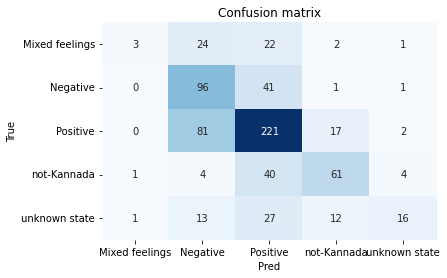

In [29]:
## Plot confusion matrix
print(metrics.classification_report(results['y'], results['neg_majority_label_bert']))
cm = metrics.confusion_matrix(results['y'], results['neg_majority_label_bert'])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()